In [1]:
import os
import random
import yaml

import tikzplotlib
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import flax.linen as nn

from priorCVAE.datasets import GPDataset
import priorCVAE.priors as priors
from priorCVAE.models import MLPDecoder
from priorCVAE.utility import load_model_params, generate_decoder_samples

import jax.config as config
config.update("jax_enable_x64", True)


In [2]:
model_dir = r"../outputs/ygh9zhfg/"
output_dir = "output_tex/"

n = 5000
n_plot = 20

plot_ls = [0.05, 0.2, 0.4, 0.6]

In [3]:
cfg_path = os.path.join(model_dir, "files", "config.yaml")
with open(cfg_path, 'r') as file:
    cfg_data = yaml.safe_load(file)

latent_dim = cfg_data["latent_dim"]["value"]
conditional = cfg_data["conditional"]["value"]
dec_activation_fn = cfg_data["dec_activation"]["value"]["_target_"]
dec_activation_fn = getattr(nn, dec_activation_fn.split(".")[-1])
kernel = getattr(priors, cfg_data["data_generator"]["value"]["kernel"]["_target_"].split(".")[-1])

x0 = cfg_data["x0"]["value"]
x1 = cfg_data["x1"]["value"]
n_data = cfg_data["n_data"]["value"]

In [4]:
x = jnp.linspace(x0, x1, n_data)

In [5]:
trained_decoder_params = load_model_params(os.path.join(model_dir, "model_intermediate"))["decoder"]

In [6]:
output_dim = trained_decoder_params["dec_out"]["bias"].shape[0]
hidden_dim = trained_decoder_params["dec_hidden_0"]["bias"].shape[0]
decoder = MLPDecoder(hidden_dim=hidden_dim, out_dim=output_dim, activations=dec_activation_fn)

In [7]:
kernel

priorCVAE.priors.kernels.SquaredExponential

## Prior Samples

In [8]:
gp_dataset = GPDataset(kernel=kernel(), x=x, sample_lengthscale=False, prior_type="non_stationary", c_lin=.4)

## PriorCVAE Samples

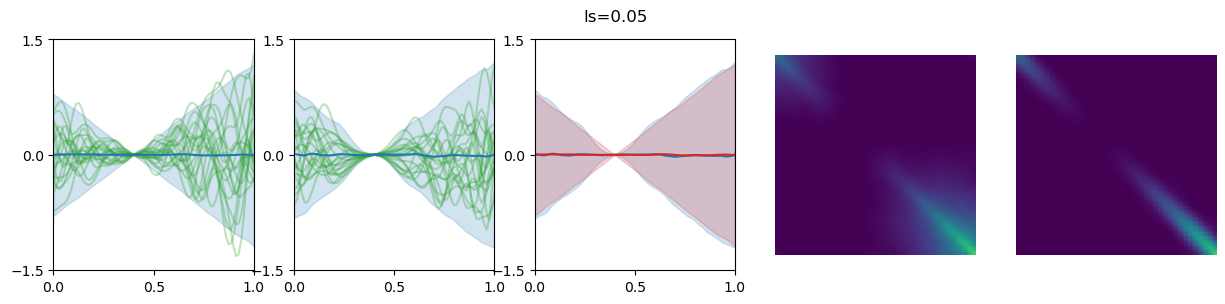

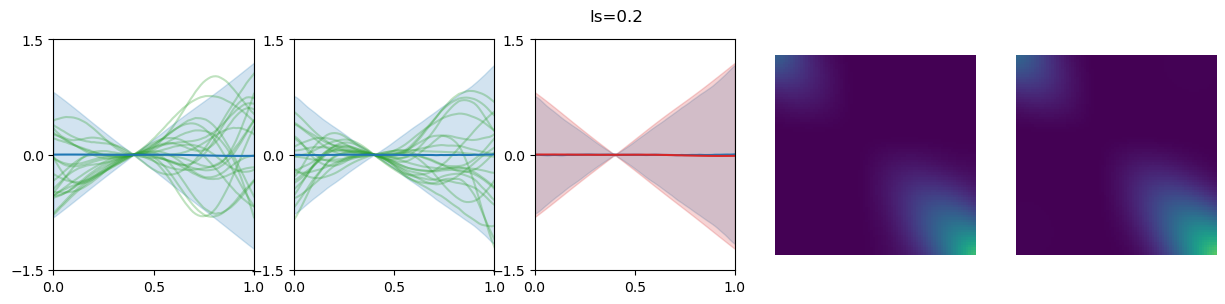

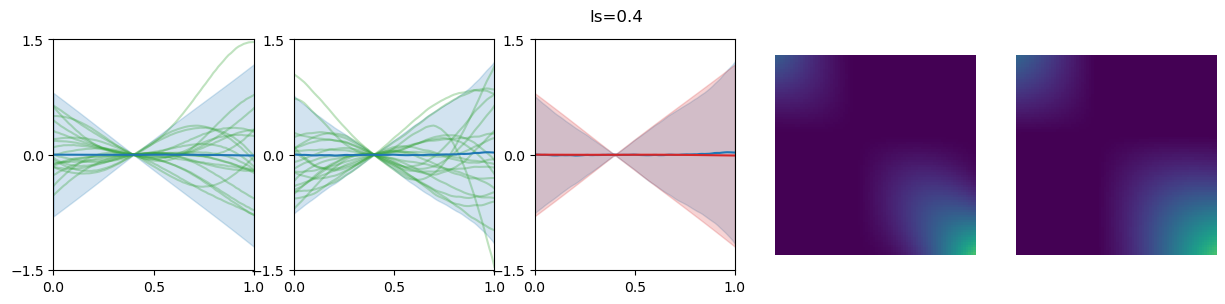

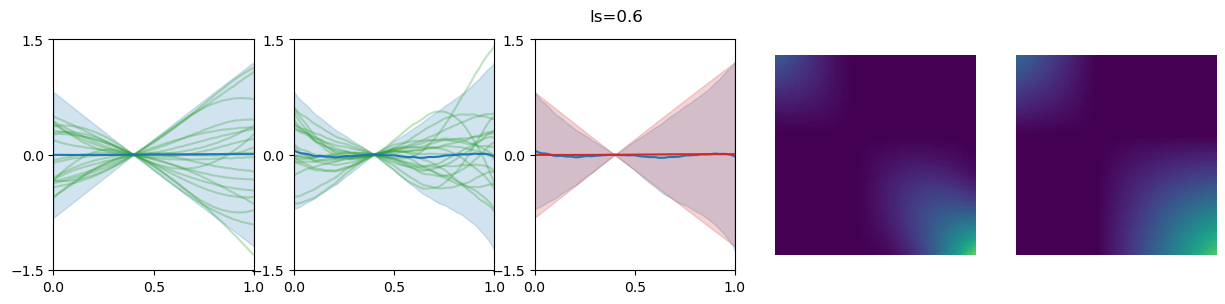

In [9]:
for ls in plot_ls:
    gp_dataset.kernel.lengthscale = ls
    gp_dataset.c_lin = .4
    _, gp_samples, _ = gp_dataset.simulatedata(n)

    gp_samples_mean = jnp.mean(gp_samples, axis=0)
    gp_samples_std = jnp.std(gp_samples, axis=0)
    gp_cov = jnp.cov(gp_samples.T)

    key = jax.random.PRNGKey(random.randint(0, 9999))
    c = None
    if conditional:
        c = ls * jnp.ones((n, 1))

    vae_samples = generate_decoder_samples(key, decoder_params=trained_decoder_params, decoder=decoder, 
                                           c=c, num_samples=n, latent_dim=latent_dim)

    vae_samples_mean = jnp.mean(vae_samples, axis=0)
    vae_samples_std = jnp.std(vae_samples, axis=0)
    vae_cov = jnp.cov(vae_samples.T)
    
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))

    for s in gp_samples[:n_plot]:
        axs[0].plot(x, s, c="tab:green", alpha=0.3)

    axs[0].plot(x, gp_samples_mean, c="tab:blue")
    axs[0].fill_between(x, gp_samples_mean + 2 * gp_samples_std, 
                        gp_samples_mean - 2 * gp_samples_std, color="tab:blue", alpha=0.2)

    for s in vae_samples[:n_plot]:
        axs[1].plot(x, s, c="tab:green", alpha=0.3)

    axs[1].plot(x, vae_samples_mean, c="tab:blue")
    axs[1].fill_between(x, vae_samples_mean + 2 * vae_samples_std, 
                        vae_samples_mean - 2 * vae_samples_std, color="tab:blue", alpha=0.2)


    axs[2].plot(x, vae_samples_mean, c="tab:blue")
    axs[2].fill_between(x, vae_samples_mean + 2 * vae_samples_std, 
                        vae_samples_mean - 2 * vae_samples_std, color="tab:blue", alpha=0.2)
    axs[2].plot(x, gp_samples_mean, c="tab:red")
    axs[2].fill_between(x, gp_samples_mean + 2 * gp_samples_std, 
                        gp_samples_mean - 2 * gp_samples_std, color="tab:red", alpha=0.2)
    axs[3].imshow(vae_cov, vmin=0, vmax=.5)
    axs[3].axis("off")
    axs[4].imshow(gp_cov, vmin=0, vmax=.5)
    axs[4].axis("off")
    
    axs[0].set_xlim([x[0], x[-1]]) 
    axs[0].set_ylim([-1.5, 1.5]) 
    axs[0].set_xticks([0, 0.5, 1.0])
    axs[0].set_yticks([-1.5, 0, 1.5])
    
    axs[1].set_xlim([x[0], x[-1]]) 
    axs[1].set_ylim([-1.5, 1.5])
    axs[1].set_xticks([0, 0.5, 1.0])
    axs[1].set_yticks([-1.5, 0, 1.5])
    
    axs[2].set_xlim([x[0], x[-1]]) 
    axs[2].set_ylim([-1.5, 1.5]) 
    axs[2].set_xticks([0, 0.5, 1.0])
    axs[2].set_yticks([-1.5, 0, 1.5])
    
    plt.suptitle(f"ls={ls}")
    plt.show()


In [10]:
output_dir = os.path.join(output_dir, "non_stationary")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

<Figure size 640x480 with 0 Axes>

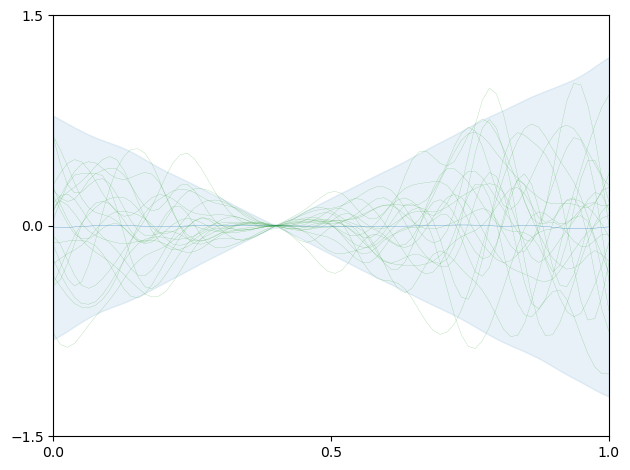

<Figure size 640x480 with 0 Axes>

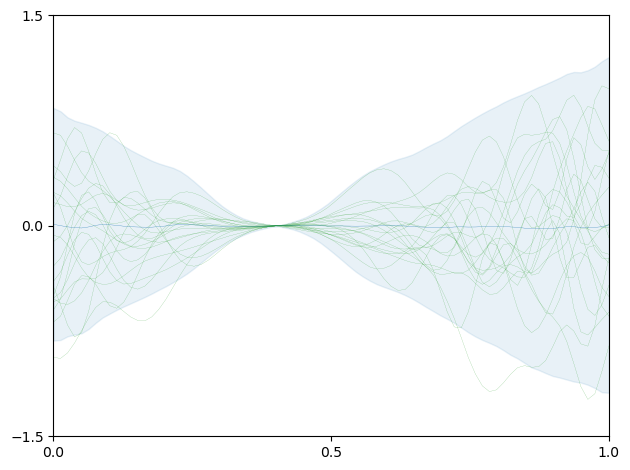

<Figure size 640x480 with 0 Axes>

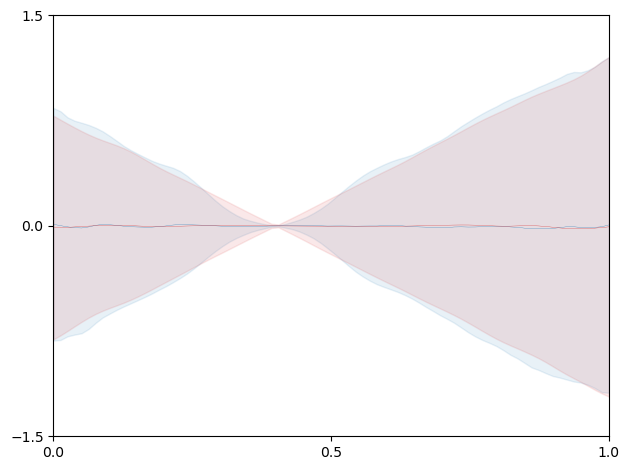

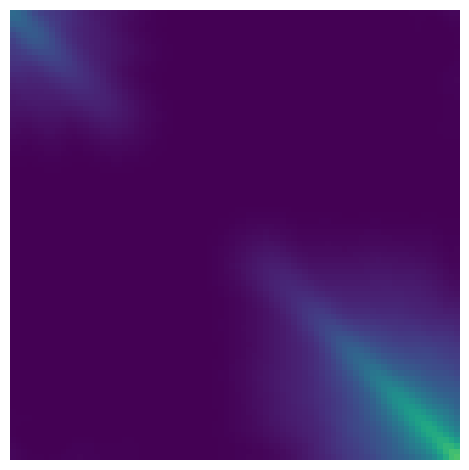

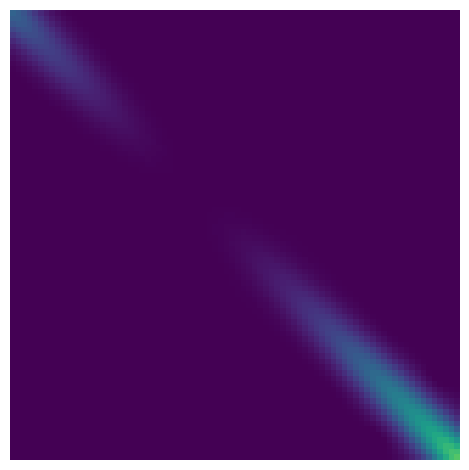

<Figure size 640x480 with 0 Axes>

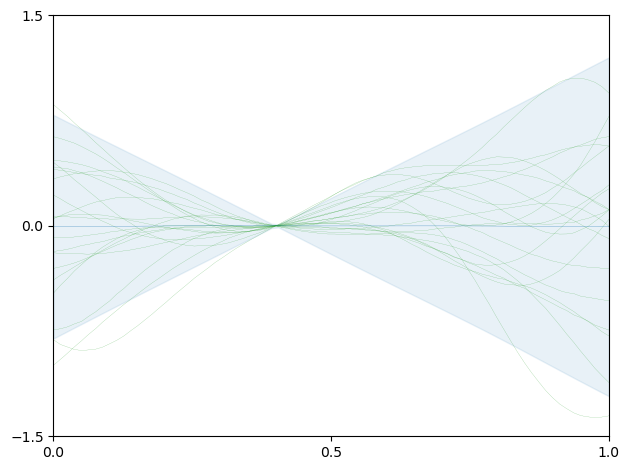

<Figure size 640x480 with 0 Axes>

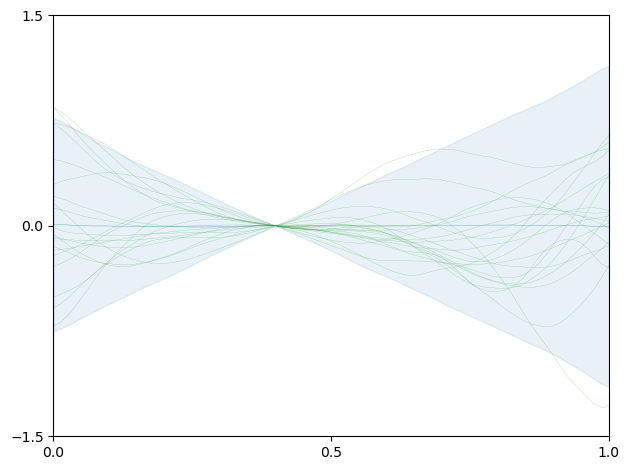

<Figure size 640x480 with 0 Axes>

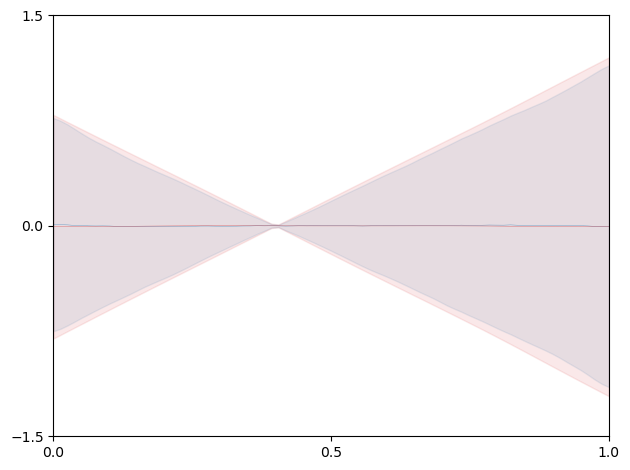

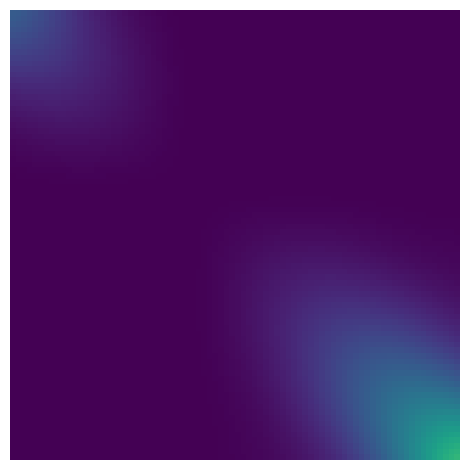

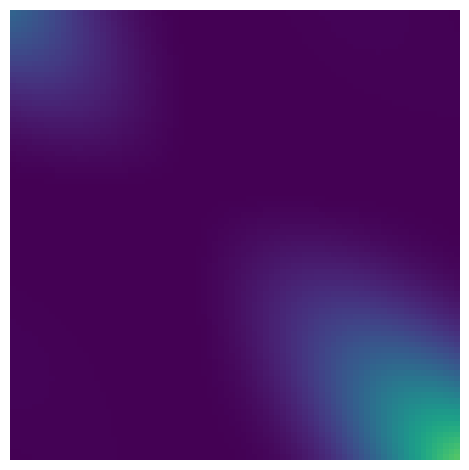

<Figure size 640x480 with 0 Axes>

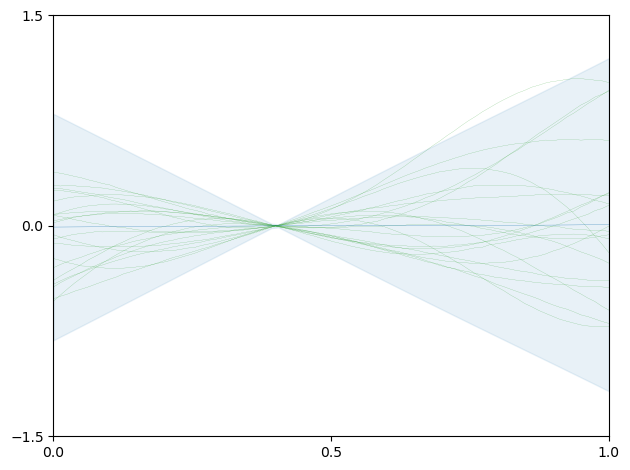

<Figure size 640x480 with 0 Axes>

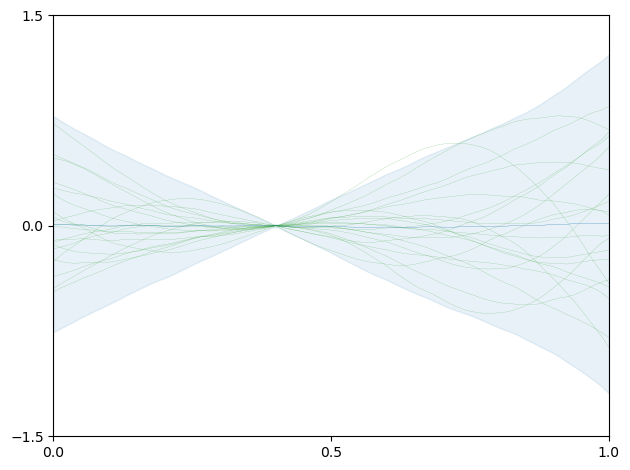

<Figure size 640x480 with 0 Axes>

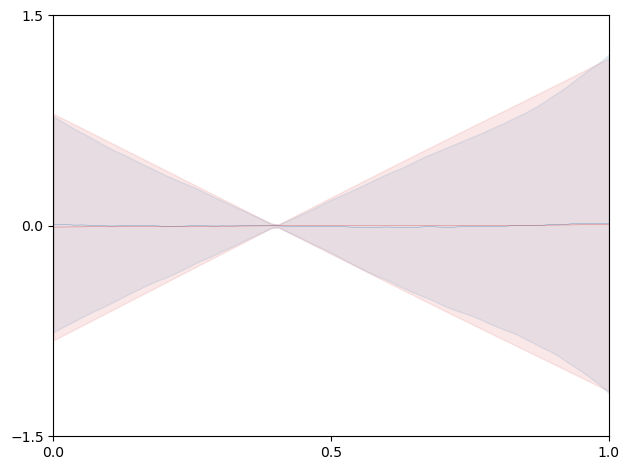

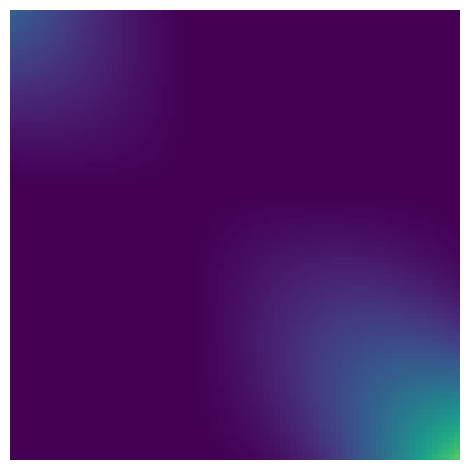

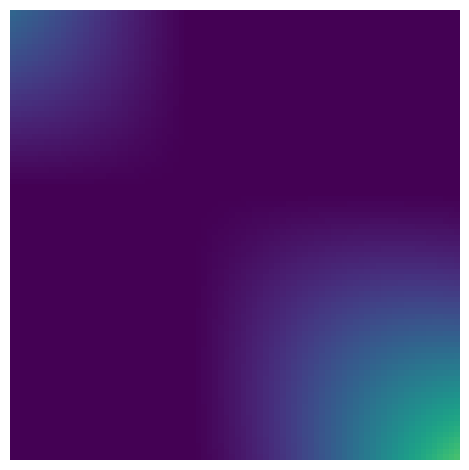

<Figure size 640x480 with 0 Axes>

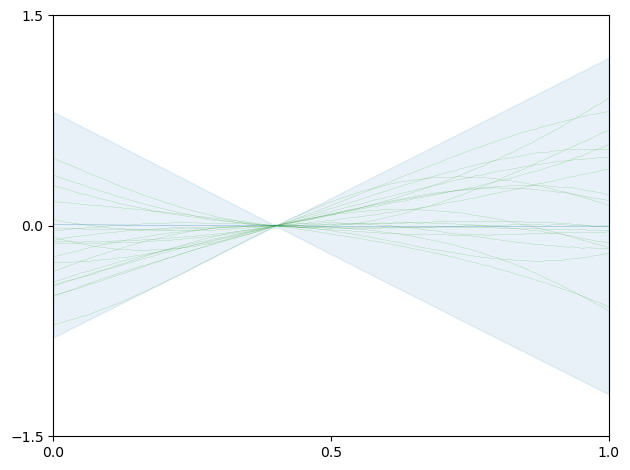

<Figure size 640x480 with 0 Axes>

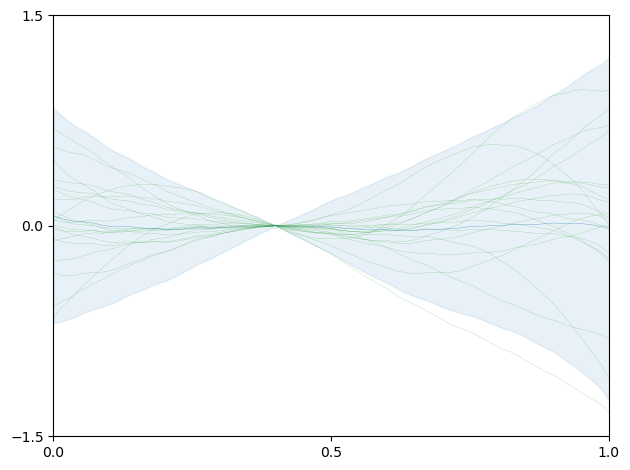

<Figure size 640x480 with 0 Axes>

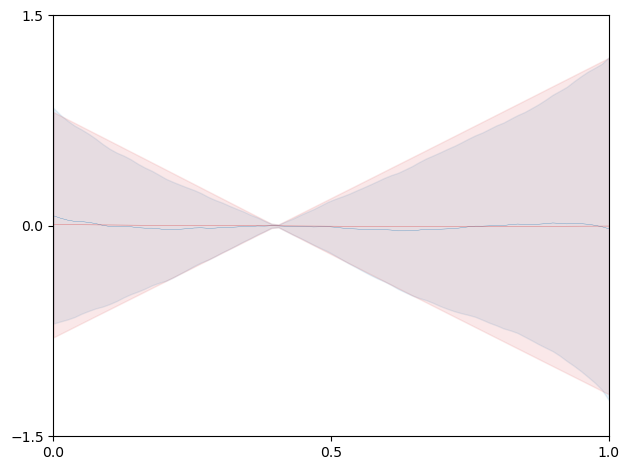

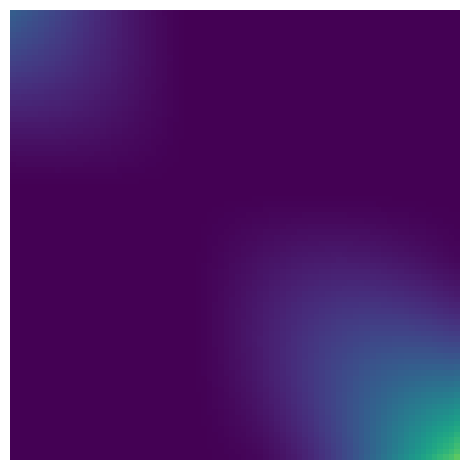

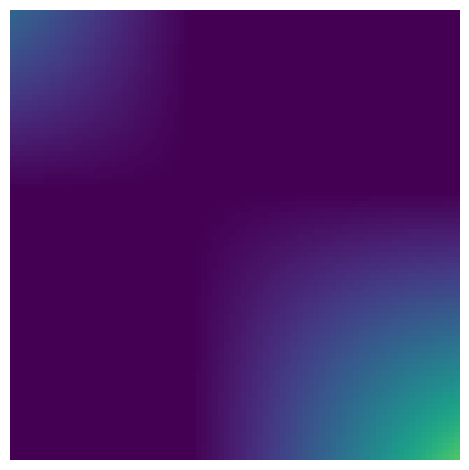

In [11]:
for ls in plot_ls:
    gp_dataset.kernel.lengthscale = ls
    gp_dataset.c_lin = .4
    _, gp_samples, _ = gp_dataset.simulatedata(n)

    gp_samples_mean = jnp.mean(gp_samples, axis=0)
    gp_samples_std = jnp.std(gp_samples, axis=0)
    gp_cov = jnp.cov(gp_samples.T)

    key = jax.random.PRNGKey(random.randint(0, 9999))
    c = None
    if conditional:
        c = ls * jnp.ones((n, 1))

    vae_samples = generate_decoder_samples(key, decoder_params=trained_decoder_params, decoder=decoder, 
                                           c=c, num_samples=n, latent_dim=latent_dim)

    vae_samples_mean = jnp.mean(vae_samples, axis=0)
    vae_samples_std = jnp.std(vae_samples, axis=0)
    vae_cov = jnp.cov(vae_samples.T)
    
    ls = str(ls).replace(".", "_")
    plt.clf()
    fig, axs = plt.subplots(1, 1)
    for s in gp_samples[:n_plot]:
        plt.plot(x, s, c="tab:green", linewidth=0.1)
    
    plt.plot(x, gp_samples_mean, c="tab:blue", linestyle="solid", linewidth=0.2)
    plt.fill_between(x, gp_samples_mean + 2 * gp_samples_std, 
                        gp_samples_mean - 2 * gp_samples_std, color="tab:blue", alpha=0.1)
    plt.xlim([x[0], x[-1]]) 
    plt.ylim([-1.5, 1.5]) 
    plt.xticks([0, 0.5, 1.0])
    plt.yticks([-1.5, 0, 1.5])
    plt.tight_layout()
    tikzplotlib.save(os.path.join(output_dir, f"GP_samples_{ls}.tex"),
                     figurewidth='\\figurewidth', figureheight='\\figureheight',
                     tex_relative_path_to_data='fig/',
                     figure=fig)
    plt.show()
    
    plt.clf()
    fig, axs = plt.subplots(1, 1)
    for s in vae_samples[:n_plot]:
        plt.plot(x, s, c="tab:green", linewidth=0.1)

    plt.plot(x, vae_samples_mean, c="tab:blue", linestyle="solid", linewidth=0.2)
    plt.fill_between(x, vae_samples_mean + 2 * vae_samples_std, 
                        vae_samples_mean - 2 * vae_samples_std, color="tab:blue", alpha=0.1)
    
    plt.xlim([x[0], x[-1]]) 
    plt.ylim([-1.5, 1.5]) 
    plt.xticks([0, 0.5, 1.0])
    plt.yticks([-1.5, 0, 1.5])
    plt.tight_layout()
    tikzplotlib.save(os.path.join(output_dir, f"VAE_samples_{ls}.tex"),
                     figurewidth='\\figurewidth', figureheight='\\figureheight',
                     tex_relative_path_to_data='fig/',
                     figure=fig)
    plt.show()
    
    plt.clf()
    fig, axs = plt.subplots(1, 1)
    plt.plot(x, vae_samples_mean, c="tab:blue", linestyle="solid", linewidth=0.2)
    plt.fill_between(x, vae_samples_mean + 2 * vae_samples_std, 
                        vae_samples_mean - 2 * vae_samples_std, color="tab:blue", alpha=0.1)
    plt.plot(x, gp_samples_mean, c="tab:red", linestyle="solid", linewidth=0.2)
    plt.fill_between(x, gp_samples_mean + 2 * gp_samples_std, 
                        gp_samples_mean - 2 * gp_samples_std, color="tab:red", alpha=0.1)
    
    plt.xlim([x[0], x[-1]]) 
    plt.ylim([-1.5, 1.5]) 
    plt.xticks([0, 0.5, 1.0])
    plt.yticks([-1.5, 0, 1.5])
    plt.tight_layout()
    tikzplotlib.save(os.path.join(output_dir, f"GP_VAE_comparison_{ls}.tex"),
                     figurewidth='\\figurewidth', figureheight='\\figureheight',
                     tex_relative_path_to_data='fig/',
                     figure=fig)
    plt.show()
    
    plt.clf()
    plt.imshow(vae_cov, vmin=0, vmax=.5)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"vae_cov_{ls}.png"), bbox_inches=0, transparent=True)
    plt.show()
    
    plt.clf()
    plt.imshow(gp_cov, vmin=0, vmax=.5)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"gp_cov_{ls}.png"), bbox_inches=0, transparent=True)
    plt.show()
    
        